In [ ]:
# Instalacja wymaganych bibliotek
!pip install torch torchvision transformers pillow ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

# Importy
import torch
import clip
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import numpy as np
from tqdm import tqdm
import requests
from io import BytesIO
import os


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-qe_8a8l9
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-qe_8a8l9
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [ ]:
# Sprawdzenie dostępności GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Załadowanie modelu CLIP
model, preprocess = clip.load("ViT-B/32", device=device)

Using device: cpu


In [ ]:
# Klasa do obsługi datasetu
class TextImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform if transform is not None else transforms.ToTensor()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        text = row['text']

        # Pobieranie obrazu z URL
        try:
            response = requests.get(row['image_url'])
            image = Image.open(BytesIO(response.content)).convert('RGB')
            if self.transform:
                image = self.transform(image)
        except:
            # W przypadku błędu zwracamy None
            image = None

        return text, image

def get_sample_data(n_samples=1000):
    """
    Pobiera próbkę danych z datasetu audiocaps
    """
    # URL do danych huggingface
    url = "https://huggingface.co/api/datasets/d0rj/audiocaps/parquet/default/train/0.parquet"

    print("Próba pobrania danych z huggingface...")
    df = pd.read_parquet(url)
    # Wybieramy tylko potrzebne kolumny
    df = df[['caption', 'youtube_id']]
    # Zmieniamy nazwy kolumn na zgodne z naszym kodem
    df = df.rename(columns={'caption': 'text', 'youtube_id': 'image_url'})
    # Wybieramy próbkę
    df = df.head(n_samples)
    print(f"Pobrano {len(df)} próbek z huggingface")
    return df

df = get_sample_data(1000)
print("\nPrzykładowe dane:")
print(df.head())
print("\nRozmiar datasetu:", len(df))

Próba pobrania danych z huggingface...
Pobrano 1000 próbek z huggingface

Przykładowe dane:
                                                text    image_url
0                A woman talks nearby as water pours  r1nicOVtvkQ
1              Multiple clanging and clanking sounds  UDGBjjwyaqE
2  The wind is blowing, insects are singing, and ...  3eJ9RynJzP8
3            The wind is blowing and rustling occurs  3eK62q7SnVU
4                                Person is whistling  3eGXNIadwGk

Rozmiar datasetu: 1000


In [ ]:
# Główna funkcja inicjalizująca
def initialize_environment(n_samples=1000):
    """
    Inicjalizuje środowisko i przygotowuje dane
    """
    print("Inicjalizacja środowiska...")

    # Pobieranie danych
    df = get_sample_data(n_samples)
    print(f"Pobrano {len(df)} próbek danych")

    # Tworzenie datasetu
    dataset = TextImageDataset(
        df,
        transform=preprocess
    )

    # Tworzenie data loadera
    dataloader = DataLoader(
        dataset,
        batch_size=32,
        shuffle=True,
        num_workers=2
    )

    return df, dataset, dataloader

# Uruchomienie inicjalizacji
df, dataset, dataloader = initialize_environment(1000)
print("Inicjalizacja zakończona!")

Inicjalizacja środowiska...
Próba pobrania danych z huggingface...
Pobrano 1000 próbek z huggingface
Pobrano 1000 próbek danych
Inicjalizacja zakończona!


In [ ]:
# Instalacja dodatkowych potrzebnych bibliotek
!pip install nltk wordcloud
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
from collections import Counter
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt

In [ ]:
# Pobieranie wszystkich potrzebnych zasobów NLTK
import nltk

def download_nltk_resources():
    resources = [
        'punkt',
        'punkt_tab'
        'stopwords',
        'wordnet',
        'averaged_perceptron_tagger',
        'omw-1.4',
    ]

    for resource in resources:
        try:
            nltk.download(resource)
            print(f"Pobrano zasób: {resource}")
        except:
            print(f"Błąd podczas pobierania zasobu: {resource}")

download_nltk_resources()

Pobrano zasób: punkt
Pobrano zasób: punkt_tabstopwords
Pobrano zasób: wordnet
Pobrano zasób: averaged_perceptron_tagger
Pobrano zasób: omw-1.4


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Error loading punkt_tabstopwords: Package
[nltk_data]     'punkt_tabstopwords' not found in index
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
class WordFrequencyAnalyzer:
    def __init__(self, texts):
        self.texts = texts
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        self.word_counts = None
        self.word_frequencies = None

    def preprocess_text(self, text):
        """Preprocessuje tekst: lowercase, usunięcie znaków specjalnych, tokenizacja"""
        # Konwersja na lowercase i usunięcie znaków specjalnych
        text = re.sub(r'[^a-zA-Z\s]', '', text.lower())

        # Tokenizacja
        tokens = word_tokenize(text)

        # Usunięcie stop words i lematyzacja
        tokens = [self.lemmatizer.lemmatize(token) for token in tokens
                 if token not in self.stop_words and len(token) > 2]

        return tokens

    def analyze(self):
        """Przeprowadza analizę częstości słów"""
        # Preprocessing wszystkich tekstów
        all_tokens = []
        for text in self.texts:
            tokens = self.preprocess_text(text)
            all_tokens.extend(tokens)

        # Obliczenie liczby wystąpień każdego słowa
        self.word_counts = Counter(all_tokens)
        total_words = sum(self.word_counts.values())

        # Obliczenie częstości względnych
        self.word_frequencies = {word: count/total_words
                               for word, count in self.word_counts.items()}

        return self.word_frequencies

    def get_rare_concepts(self, threshold=0.0004):
        """Zwraca słowa występujące rzadziej niż próg"""
        if self.word_frequencies is None:
            self.analyze()

        rare_words = {word: freq for word, freq in self.word_frequencies.items()
                     if freq < threshold}
        return rare_words

    def plot_frequency_distribution(self, top_n=50):
        """Tworzy wykres rozkładu częstości słów"""
        plt.figure(figsize=(15, 8))

        # Sortowanie słów według częstości
        sorted_freq = dict(sorted(self.word_frequencies.items(),
                                key=lambda x: x[1], reverse=True)[:top_n])

        # Tworzenie wykresu
        plt.bar(range(len(sorted_freq)), list(sorted_freq.values()))
        plt.xticks(range(len(sorted_freq)), list(sorted_freq.keys()),
                  rotation=45, ha='right')
        plt.title('Word Frequency Distribution (Top Words)')
        plt.xlabel('Words')
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()

    def plot_log_distribution(self):
        """Tworzy wykres rozkładu częstości w skali logarytmicznej (jak w Figure 2 z pracy)"""
        frequencies = list(self.word_frequencies.values())

        plt.figure(figsize=(12, 6))
        plt.hist(frequencies, bins=50, log=True)
        plt.title('Word Frequency Distribution (Log Scale)')
        plt.xlabel('Frequency')
        plt.ylabel('Count (log scale)')
        plt.yscale('log')
        plt.xscale('log')
        plt.grid(True)
        plt.show()

Znaleziono 490 rzadkich konceptów

Przykładowe rzadkie koncepty i ich częstości:
cruise: 0.000187
whole: 0.000187
sprayed: 0.000374
middle: 0.000374
precedes: 0.000187
fly: 0.000374
decelerating: 0.000374
whine: 0.000374
hear: 0.000187
dove: 0.000187

Tworzenie wizualizacji...
1. Rozkład częstości słów:


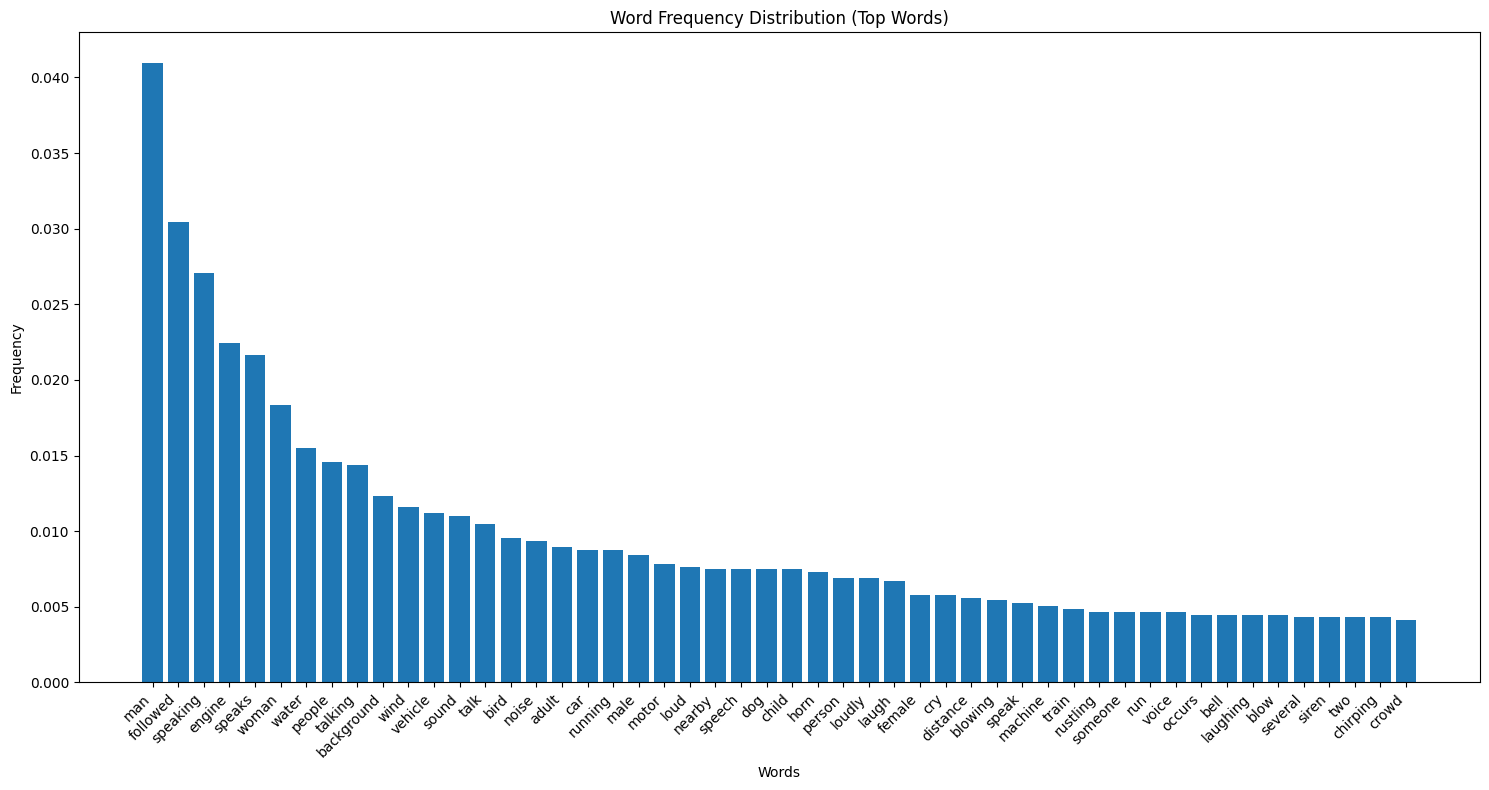


2. Rozkład logarytmiczny:


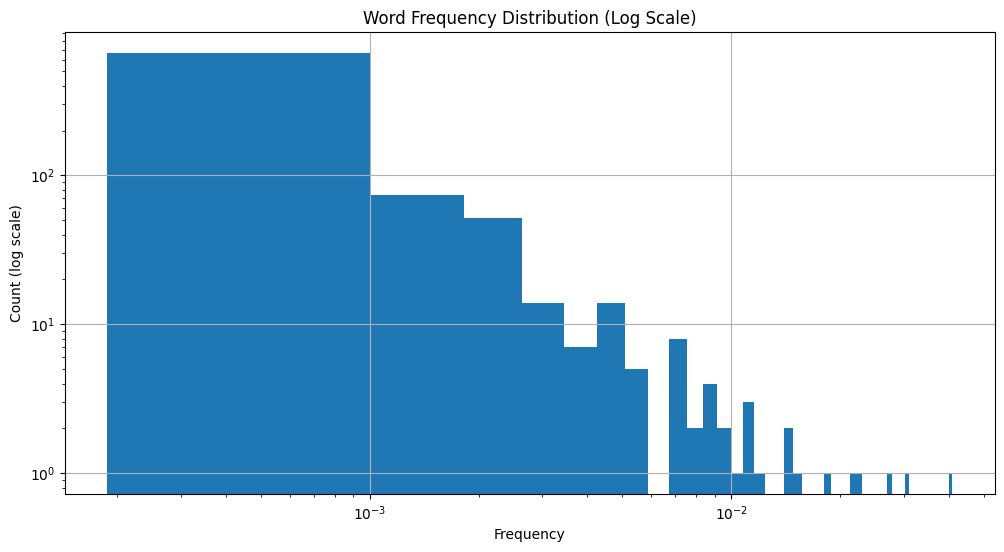

In [ ]:
# Użycie analizatora
def run_frequency_analysis(df):
    # Inicjalizacja analizatora
    analyzer = WordFrequencyAnalyzer(df['text'])

    # Przeprowadzenie analizy
    frequencies = analyzer.analyze()

    # Znalezienie rzadkich konceptów
    rare_concepts = analyzer.get_rare_concepts()

    print(f"Znaleziono {len(rare_concepts)} rzadkich konceptów")
    print("\nPrzykładowe rzadkie koncepty i ich częstości:")
    for word, freq in list(rare_concepts.items())[:10]:
        print(f"{word}: {freq:.6f}")

    # Wizualizacje
    print("\nTworzenie wizualizacji...")

    print("1. Rozkład częstości słów:")
    analyzer.plot_frequency_distribution()

    print("\n2. Rozkład logarytmiczny:")
    analyzer.plot_log_distribution()

    return analyzer

# Uruchomienie analizy
analyzer = run_frequency_analysis(df)

In [ ]:
# 5. Zapisanie wyników do DataFrame
def save_analysis_results(analyzer):
    results_df = pd.DataFrame({
        'word': list(analyzer.word_frequencies.keys()),
        'frequency': list(analyzer.word_frequencies.values())
    })

    # Sortowanie według częstości
    results_df = results_df.sort_values('frequency', ascending=False)

    # Dodanie flagi dla rzadkich konceptów
    results_df['is_rare'] = results_df['frequency'] < 0.0004

    # Zapisanie do CSV
    results_df.to_csv('word_frequency_analysis.csv', index=False)
    return results_df

results_df = save_analysis_results(analyzer)
print("Top 10 najczęstszych słów:")
print(results_df.head(10))

Top 10 najczęstszych słów:
          word  frequency  is_rare
20         man   0.040935    False
32    followed   0.030467    False
30    speaking   0.027103    False
28      engine   0.022430    False
53      speaks   0.021682    False
0        woman   0.018318    False
3        water   0.015514    False
95      people   0.014579    False
34     talking   0.014393    False
67  background   0.012336    False


In [ ]:
# 1. Importy i instalacja dodatkowych bibliotek
!pip install scikit-learn umap-learn

import torch
import clip
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import umap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.0 MB/s eta 0:00:00


In [ ]:
class SemanticAnalyzer:
    def __init__(self, words, clip_model, device, threshold=4.8):
        """
        Inicjalizacja analizatora semantycznego

        Args:
            words: lista słów do analizy
            clip_model: załadowany model CLIP
            device: urządzenie (cuda/cpu)
            threshold: próg odległości semantycznej (jak w pracy - 4.8)
        """
        self.words = words
        self.model = clip_model
        self.device = device
        self.threshold = threshold
        self.embeddings = None
        self.distances = None
        self.semantic_frequencies = None

    def generate_embeddings(self):
        """Generuje embeddingi CLIP dla wszystkich słów"""
        print("Generowanie embeddingów CLIP...")

        # Tokenizacja tekstu
        text_tokens = clip.tokenize(self.words).to(self.device)

        # Generowanie embeddingów
        with torch.no_grad():
            text_features = self.model.encode_text(text_tokens)
            text_features /= text_features.norm(dim=-1, keepdim=True)

        self.embeddings = text_features.cpu().numpy()
        return self.embeddings

    def calculate_distances(self):
        """Oblicza macierz odległości między wszystkimi słowami"""
        if self.embeddings is None:
            self.generate_embeddings()

        print("Obliczanie odległości semantycznych...")

        # Obliczanie odległości L2 między wszystkimi parami embeddingów
        self.distances = np.zeros((len(self.words), len(self.words)))
        for i in range(len(self.words)):
            for j in range(len(self.words)):
                self.distances[i,j] = np.linalg.norm(
                    self.embeddings[i] - self.embeddings[j]
                )

        return self.distances

    def find_semantic_neighbors(self):
        """Znajduje semantycznych sąsiadów dla każdego słowa"""
        if self.distances is None:
            self.calculate_distances()

        semantic_neighbors = {}
        for i, word in enumerate(self.words):
            # Znalezienie wszystkich słów w odległości mniejszej niż próg
            neighbors = [self.words[j] for j in range(len(self.words))
                        if 0 < self.distances[i,j] < self.threshold]
            semantic_neighbors[word] = neighbors

        return semantic_neighbors

    def calculate_semantic_frequency(self, word_frequencies):
        """
        Oblicza częstość semantyczną dla każdego słowa
        (uwzględniając częstości semantycznie podobnych słów)
        """
        semantic_neighbors = self.find_semantic_neighbors()
        semantic_frequencies = {}

        for word in self.words:
            # Częstość własna słowa
            own_freq = word_frequencies.get(word, 0)

            # Dodanie częstości sąsiadów semantycznych
            neighbor_freq = sum(word_frequencies.get(neighbor, 0)
                              for neighbor in semantic_neighbors[word])

            semantic_frequencies[word] = own_freq + neighbor_freq

        self.semantic_frequencies = semantic_frequencies
        return semantic_frequencies

    def visualize_semantic_space(self, method='tsne'):
        """
        Wizualizuje przestrzeń semantyczną używając t-SNE lub UMAP
        """
        if self.embeddings is None:
            self.generate_embeddings()

        if method == 'tsne':
            # Redukcja wymiarowości używając t-SNE
            reducer = TSNE(n_components=2, random_state=42)
        else:
            # Redukcja wymiarowości używając UMAP
            reducer = umap.UMAP(random_state=42)

        embeddings_2d = reducer.fit_transform(self.embeddings)

        # Tworzenie wykresu
        plt.figure(figsize=(15, 10))
        plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5)

        # Dodanie etykiet dla punktów
        for i, word in enumerate(self.words):
            plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]))

        plt.title(f'Semantic Space Visualization ({method.upper()})')
        plt.tight_layout()
        plt.show()

    def plot_semantic_vs_word_frequency(self, word_frequencies):
        """
        Tworzy wykres porównujący częstość słów z częstością semantyczną
        """
        if self.semantic_frequencies is None:
            self.calculate_semantic_frequency(word_frequencies)

        plt.figure(figsize=(12, 8))
        plt.scatter(
            [word_frequencies[w] for w in self.words],
            [self.semantic_frequencies[w] for w in self.words],
            alpha=0.5
        )

        plt.xlabel('Word Frequency')
        plt.ylabel('Semantic Frequency')
        plt.title('Word Frequency vs Semantic Frequency')
        plt.yscale('log')
        plt.xscale('log')
        plt.grid(True)

        plt.show()

Generowanie embeddingów CLIP...
Obliczanie odległości semantycznych...

Tworzenie wizualizacji przestrzeni semantycznej...


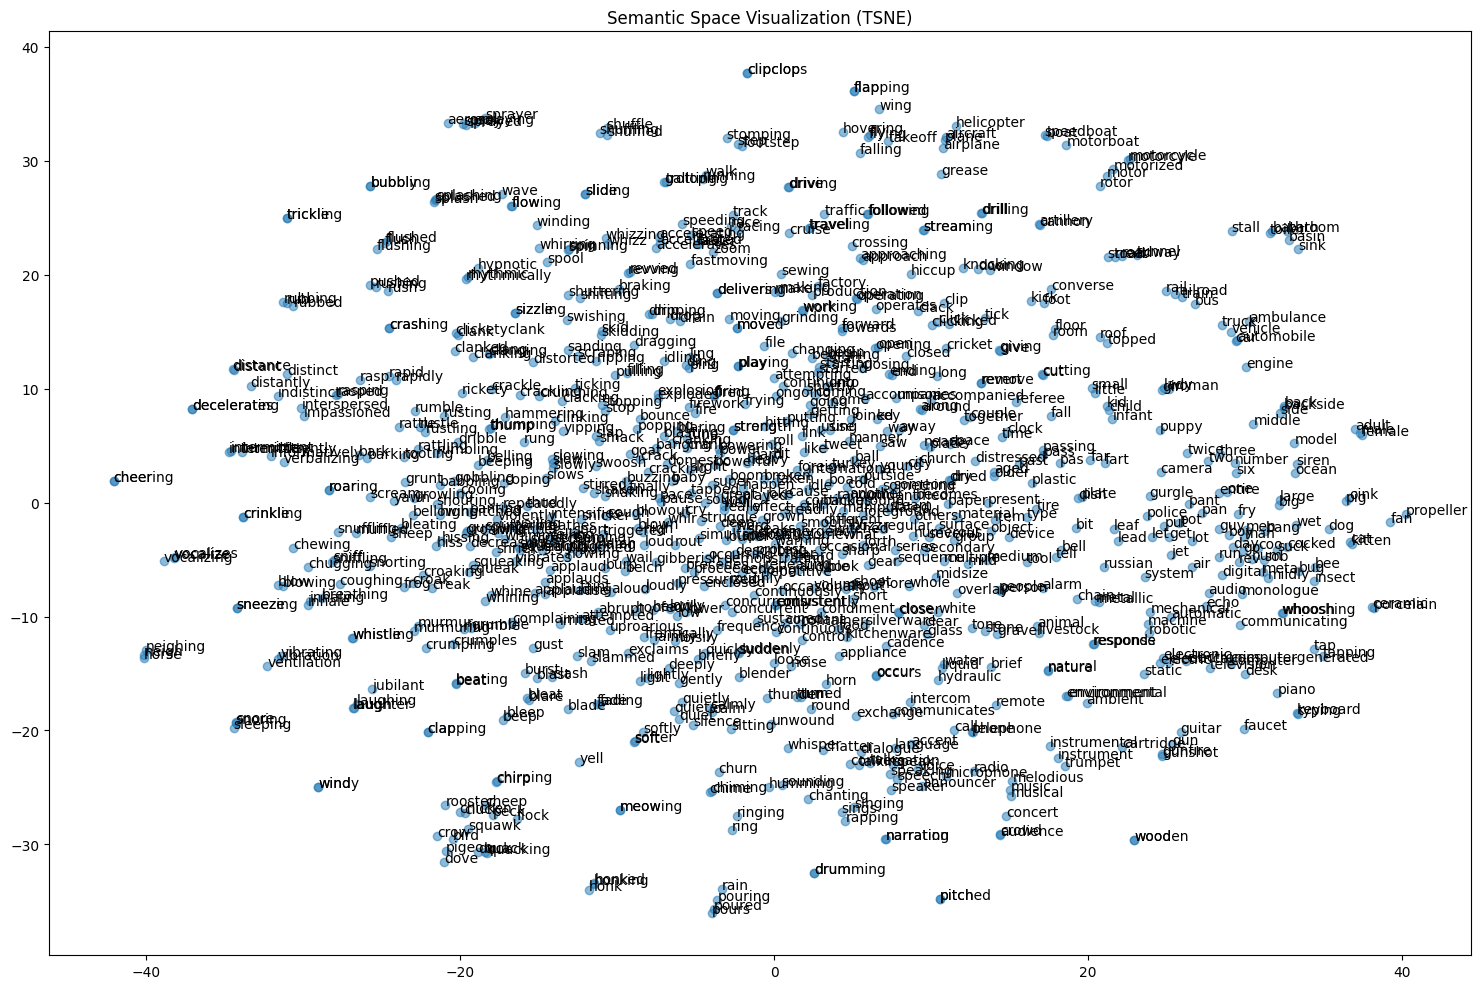


Tworzenie wykresu porównania częstości...


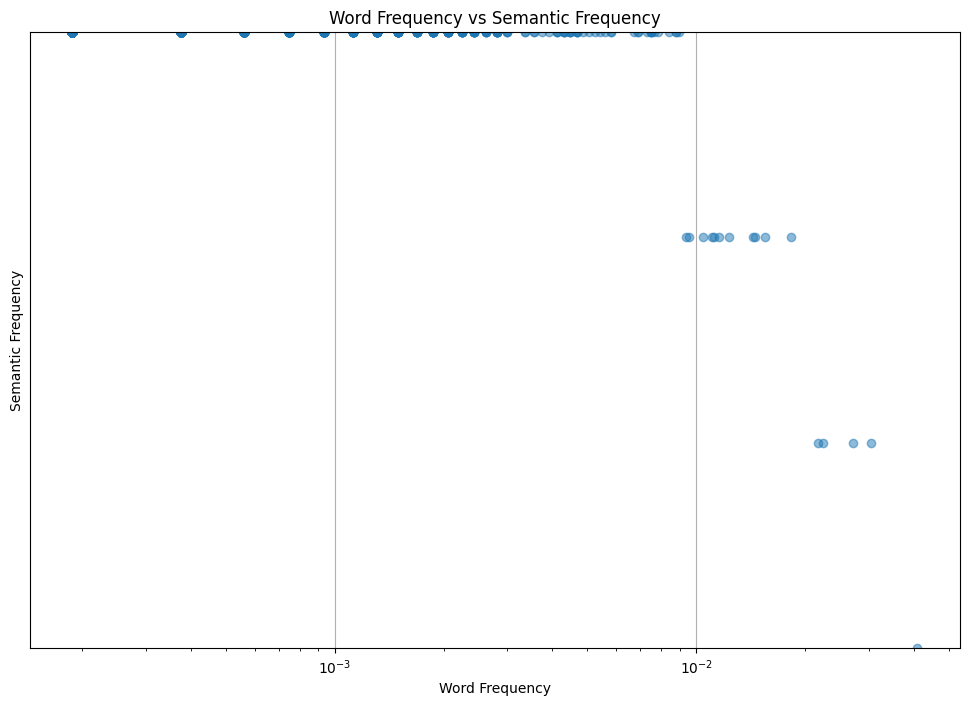

In [ ]:
# Funkcja do uruchomienia analizy semantycznej
def run_semantic_analysis(results_df, clip_model, device):
    # Przygotowanie listy słów do analizy
    words = results_df['word'].tolist()
    word_frequencies = dict(zip(results_df['word'], results_df['frequency']))

    # Inicjalizacja analizatora
    analyzer = SemanticAnalyzer(words, clip_model, device)

    # Generowanie embeddingów i obliczanie odległości
    embeddings = analyzer.generate_embeddings()
    distances = analyzer.calculate_distances()

    # Znalezienie sąsiadów semantycznych
    semantic_neighbors = analyzer.find_semantic_neighbors()

    # Obliczenie częstości semantycznych
    semantic_frequencies = analyzer.calculate_semantic_frequency(word_frequencies)

    # Wizualizacje
    print("\nTworzenie wizualizacji przestrzeni semantycznej...")
    analyzer.visualize_semantic_space('tsne')

    print("\nTworzenie wykresu porównania częstości...")
    analyzer.plot_semantic_vs_word_frequency(word_frequencies)

    # Dodanie wyników do DataFrame
    results_df['semantic_frequency'] = results_df['word'].map(semantic_frequencies)
    results_df['semantic_neighbor_count'] = results_df['word'].map(
        lambda w: len(semantic_neighbors[w])
    )

    return results_df, analyzer

# 4. Uruchomienie analizy
updated_results_df, semantic_analyzer = run_semantic_analysis(results_df, model, device)

In [ ]:
# Importy
!pip install spacy
!python -m spacy download en_core_web_sm

import spacy
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 66.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
class ConceptCategorizer:
    def __init__(self):
        """Inicjalizacja kategoryzatora konceptów"""
        self.nlp = spacy.load('en_core_web_sm')

        # Predefinowane listy kategorii
        self.art_styles = {
            'cubism', 'impressionism', 'abstract', 'surrealism', 'modernism',
            'contemporary', 'minimalism', 'baroque', 'renaissance', 'pop art',
            'anime', 'cartoon', 'digital art', '3d', 'watercolor', 'oil painting',
            'sketch', 'photography', 'illustration', 'graphic design'
        }

        # Możemy dodać więcej kategorii
        self.colors = {'red', 'blue', 'green', 'yellow', 'purple', 'white', 'black'}
        self.materials = {'wood', 'metal', 'glass', 'plastic', 'ceramic', 'paper'}

    def categorize_concept(self, word):
        """Kategoryzuje pojedyncze słowo"""
        # Analiza słowa przez spaCy
        doc = self.nlp(word)

        # Sprawdzenie czy jest to styl artystyczny
        if word.lower() in self.art_styles:
            return 'art_style'

        # Sprawdzenie części mowy i innych cech
        main_token = doc[0]

        if main_token.pos_ == 'NOUN':
            if main_token.ent_type_ == 'PERSON':
                return 'person'
            elif main_token.ent_type_ == 'ORG':
                return 'organization'
            elif main_token.ent_type_ == 'GPE':
                return 'location'
            else:
                return 'object'
        elif main_token.pos_ == 'ADJ':
            if word.lower() in self.colors:
                return 'color'
            else:
                return 'attribute'
        elif main_token.pos_ == 'VERB':
            return 'action'

        return 'other'

    def analyze_vulnerability(self, row):
        """Analizuje podatność konceptu na podstawie jego cech"""
        vulnerability_score = 0

        # Rzadkość występowania (większa = bardziej podatny)
        frequency_factor = 1 - row['frequency']
        vulnerability_score += frequency_factor * 0.4

        # Izolacja semantyczna (większa = bardziej podatny)
        semantic_isolation = 1 - (row['semantic_neighbor_count'] / 100)  # normalizacja
        vulnerability_score += semantic_isolation * 0.3

        # Wpływ kategorii (style są bardziej podatne niż obiekty)
        category_weights = {
            'art_style': 0.3,
            'object': 0.2,
            'attribute': 0.15,
            'action': 0.1,
            'other': 0.05
        }
        vulnerability_score += category_weights.get(row['category'], 0.1) * 0.3

        return vulnerability_score

In [ ]:
class ConceptAnalyzer:
    def __init__(self, df):
        """
        Inicjalizacja analizatora konceptów

        Args:
            df: DataFrame z wynikami poprzednich analiz
        """
        self.df = df
        self.categorizer = ConceptCategorizer()

    def categorize_all_concepts(self):
        """Kategoryzuje wszystkie koncepty w DataFrame"""
        print("Kategoryzacja konceptów...")
        self.df['category'] = self.df['word'].apply(self.categorizer.categorize_concept)

        # Dodanie oceny podatności
        print("Analiza podatności...")
        self.df['vulnerability_score'] = self.df.apply(
            self.categorizer.analyze_vulnerability, axis=1
        )

        return self.df

    def analyze_category_statistics(self):
        """Analizuje statystyki dla każdej kategorii"""
        stats = {}
        for category in self.df['category'].unique():
            category_data = self.df[self.df['category'] == category]
            stats[category] = {
                'count': len(category_data),
                'avg_frequency': category_data['frequency'].mean(),
                'avg_semantic_freq': category_data['semantic_frequency'].mean(),
                'avg_vulnerability': category_data['vulnerability_score'].mean(),
                'most_vulnerable': category_data.nlargest(5, 'vulnerability_score')['word'].tolist()
            }
        return stats

    def plot_category_vulnerability(self):
        """Wizualizuje podatność różnych kategorii"""
        plt.figure(figsize=(12, 6))
        sns.boxplot(x='category', y='vulnerability_score', data=self.df)
        plt.xticks(rotation=45)
        plt.title('Vulnerability Scores by Category')
        plt.tight_layout()
        plt.show()

    def plot_vulnerability_heatmap(self):
        """Tworzy heatmapę pokazującą relacje między różnymi metrykami"""
        metrics = ['frequency', 'semantic_frequency', 'semantic_neighbor_count',
                  'vulnerability_score']

        correlation_matrix = self.df[metrics].corr()

        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
        plt.title('Correlation between Different Metrics')
        plt.tight_layout()
        plt.show()

    def get_most_vulnerable_concepts(self, n=20):
        """Zwraca n najbardziej podatnych konceptów"""
        return self.df.nlargest(n, 'vulnerability_score')[
            ['word', 'category', 'vulnerability_score', 'frequency', 'semantic_frequency']
        ]

Kategoryzacja konceptów...
Analiza podatności...

Statystyki kategorii:

OBJECT:
Liczba konceptów: 268
Średnia podatność: -1.8146
Najbardziej podatne: automobile, pitch, strength, day, cannon

ACTION:
Liczba konceptów: 379
Średnia podatność: -1.8444
Najbardziej podatne: topped, sleeping, dove, intercom, galloping

OTHER:
Liczba konceptów: 121
Średnia podatność: -1.8594
Najbardziej podatne: gust, violently, intermittley, gibberish, really

ATTRIBUTE:
Liczba konceptów: 85
Średnia podatność: -1.8293
Najbardziej podatne: regular, clear, windy, natural, powerful

ORGANIZATION:
Liczba konceptów: 4
Średnia podatność: -1.8443
Najbardziej podatne: spool, flap, air, coo

PERSON:
Liczba konceptów: 2
Średnia podatność: -1.8443
Najbardziej podatne: croak, motorboat

Tworzenie wizualizacji...


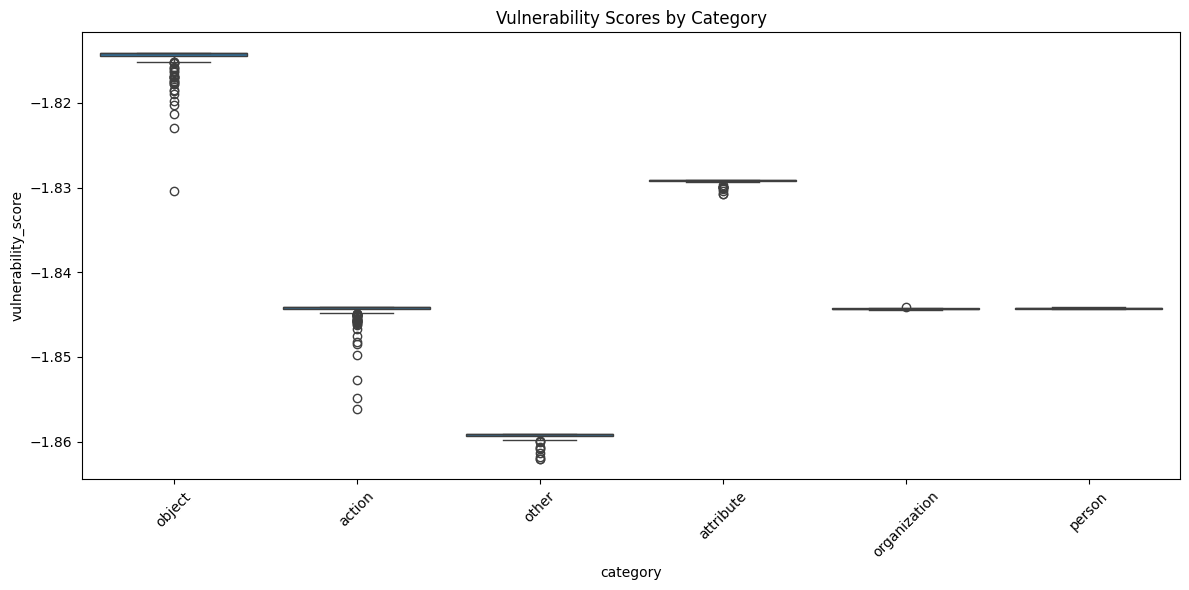

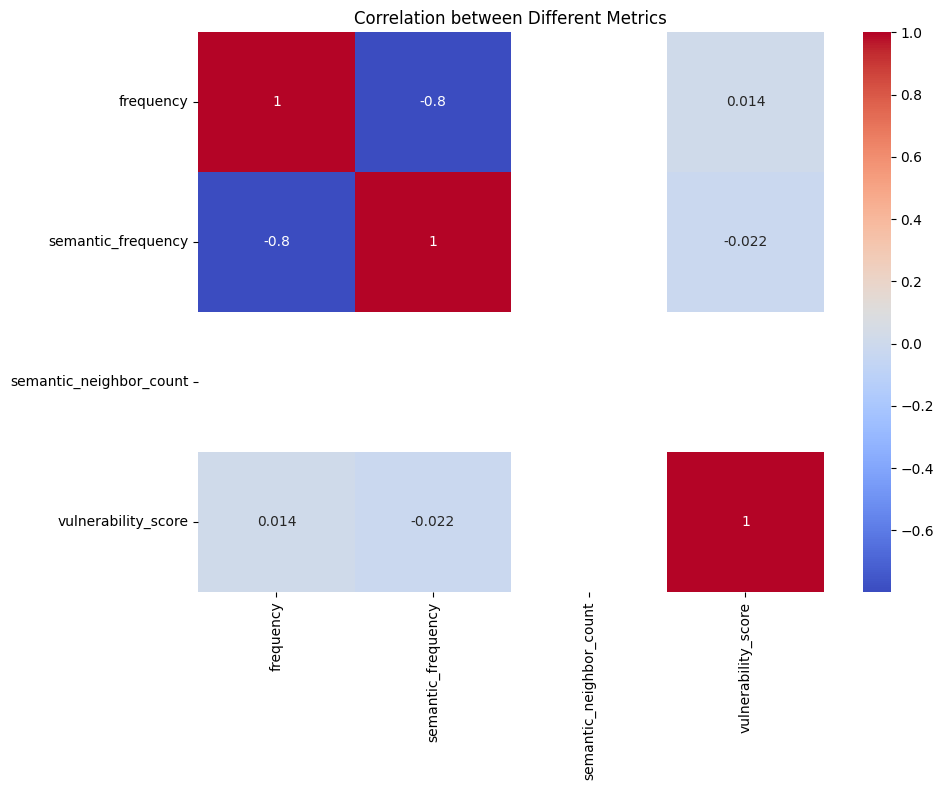


Najbardziej podatne koncepty:
            word category  vulnerability_score  frequency  semantic_frequency
727   automobile   object            -1.814075   0.000187                 1.0
730        pitch   object            -1.814075   0.000187                 1.0
84      strength   object            -1.814075   0.000187                 1.0
746          day   object            -1.814075   0.000187                 1.0
748       cannon   object            -1.814075   0.000187                 1.0
750      overlay   object            -1.814075   0.000187                 1.0
738    livestock   object            -1.814075   0.000187                 1.0
742          bit   object            -1.814075   0.000187                 1.0
747    artillery   object            -1.814075   0.000187                 1.0
691      control   object            -1.814075   0.000187                 1.0
689       device   object            -1.814075   0.000187                 1.0
688        sniff   object        

In [ ]:
# Funkcja do uruchomienia pełnej analizy
def run_concept_analysis(df):
    # Inicjalizacja analizatora
    analyzer = ConceptAnalyzer(df)

    # Kategoryzacja i analiza podatności
    df = analyzer.categorize_all_concepts()

    # Analiza statystyk kategorii
    stats = analyzer.analyze_category_statistics()

    print("\nStatystyki kategorii:")
    for category, stat in stats.items():
        print(f"\n{category.upper()}:")
        print(f"Liczba konceptów: {stat['count']}")
        print(f"Średnia podatność: {stat['avg_vulnerability']:.4f}")
        print(f"Najbardziej podatne: {', '.join(stat['most_vulnerable'])}")

    # Wizualizacje
    print("\nTworzenie wizualizacji...")
    analyzer.plot_category_vulnerability()
    analyzer.plot_vulnerability_heatmap()

    # Najbardziej podatne koncepty
    print("\nNajbardziej podatne koncepty:")
    print(analyzer.get_most_vulnerable_concepts())

    return df, analyzer

# Uruchomienie analizy
final_df, concept_analyzer = run_concept_analysis(updated_results_df)

In [ ]:
# Zapisanie wyników
def save_analysis_results(df):
    # Zapisanie pełnych wyników
    df.to_csv('concept_analysis_results.csv', index=False)

    # Zapisanie podsumowania dla każdej kategorii
    category_summary = df.groupby('category').agg({
        'word': 'count',
        'frequency': 'mean',
        'semantic_frequency': 'mean',
        'vulnerability_score': ['mean', 'min', 'max']
    }).round(4)

    category_summary.to_csv('category_summary.csv')

    # Zapisanie listy najbardziej podatnych konceptów
    most_vulnerable = df.nlargest(50, 'vulnerability_score')[
        ['word', 'category', 'vulnerability_score']
    ]
    most_vulnerable.to_csv('most_vulnerable_concepts.csv', index=False)

save_analysis_results(final_df)

In [ ]:
import pandas as pd
import numpy as np
from typing import List, Tuple
import torch

class WordPairSelector:
    def __init__(self, final_df, clip_model, device):
        """
        Inicjalizacja selektora par słów

        Args:
            final_df: DataFrame z wszystkimi analizami
            clip_model: model CLIP do obliczania podobieństwa semantycznego
            device: urządzenie (cuda/cpu)
        """
        self.df = final_df
        self.model = clip_model
        self.device = device

    def calculate_replacement_score(self, word1: str, word2: str) -> float:
        """
        Oblicza wynik dopasowania dla potencjalnej pary zamienników

        Wyższy wynik oznacza lepsze dopasowanie do zamiany
        """
        word1_data = self.df[self.df['word'] == word1].iloc[0]
        word2_data = self.df[self.df['word'] == word2].iloc[0]

        # Obliczanie odległości semantycznej używając CLIP
        with torch.no_grad():
            text_tokens = clip.tokenize([word1, word2]).to(self.device)
            text_features = self.model.encode_text(text_tokens)
            text_features /= text_features.norm(dim=-1, keepdim=True)
            semantic_distance = torch.dist(text_features[0], text_features[1]).item()

        # Komponenty wyniku
        vulnerability_diff = abs(word1_data['vulnerability_score'] - word2_data['vulnerability_score'])
        frequency_ratio = min(word1_data['frequency'], word2_data['frequency']) / max(word1_data['frequency'], word2_data['frequency'])
        semantic_isolation_balance = abs(word1_data['semantic_neighbor_count'] - word2_data['semantic_neighbor_count'])

        # Warunki idealne dla par do zamiany (zgodnie z pracą):
        # 1. Jedno słowo powinno być bardziej podatne
        # 2. Słowa powinny mieć podobną częstość występowania
        # 3. Słowa powinny być semantycznie różne
        # 4. Preferowane pary obiekt-obiekt lub styl-styl

        category_match = 1.0 if word1_data['category'] == word2_data['category'] else 0.5

        score = (
            vulnerability_diff * 0.3 +  # Różnica w podatności
            frequency_ratio * 0.2 +     # Podobieństwo częstości
            semantic_distance * 0.3 +    # Różnica semantyczna
            category_match * 0.2        # Dopasowanie kategorii
        )

        return score

    def find_best_pairs(self, n_pairs: int = 5) -> List[Tuple[str, str, float]]:
        """
        Znajduje n najlepszych par słów do zamiany
        """
        # Wybieramy najbardziej podatne słowa jako kandydatów
        candidates = self.df.nlargest(20, 'vulnerability_score')['word'].tolist()

        pairs = []
        for i, word1 in enumerate(candidates):
            for word2 in candidates[i+1:]:
                score = self.calculate_replacement_score(word1, word2)
                pairs.append((word1, word2, score))

        # Sortowanie par według wyniku i wybór najlepszych
        pairs.sort(key=lambda x: x[2], reverse=True)

        # Upewniamy się, że nie wybieramy tych samych słów wielokrotnie
        selected_pairs = []
        used_words = set()

        for word1, word2, score in pairs:
            if len(selected_pairs) >= n_pairs:
                break
            if word1 not in used_words and word2 not in used_words:
                selected_pairs.append((word1, word2, score))
                used_words.add(word1)
                used_words.add(word2)

        return selected_pairs

def print_pair_details(pairs: List[Tuple[str, str, float]], df: pd.DataFrame):
    """
    Wyświetla szczegółowe informacje o wybranych parach
    """
    print("\nWybrane pary słów do zamiany:")
    print("\n{:<15} {:<15} {:<10} {:<15} {:<15} {:<10}".format(
        "Słowo 1", "Słowo 2", "Wynik", "Kategoria 1", "Kategoria 2", "Różnica podatności"
    ))
    print("-" * 80)

    for word1, word2, score in pairs:
        word1_data = df[df['word'] == word1].iloc[0]
        word2_data = df[df['word'] == word2].iloc[0]

        vuln_diff = abs(word1_data['vulnerability_score'] - word2_data['vulnerability_score'])

        print("{:<15} {:<15} {:<10.3f} {:<15} {:<15} {:<10.3f}".format(
            word1, word2, score,
            word1_data['category'], word2_data['category'],
            vuln_diff
        ))

        print(f"\nSzczegóły dla pary {word1} - {word2}:")
        print(f"Częstości: {word1}: {word1_data['frequency']:.6f}, {word2}: {word2_data['frequency']:.6f}")
        print(f"Podatność: {word1}: {word1_data['vulnerability_score']:.3f}, {word2}: {word2_data['vulnerability_score']:.3f}")
        print(f"Liczba sąsiadów semantycznych: {word1}: {word1_data['semantic_neighbor_count']}, {word2}: {word2_data['semantic_neighbor_count']}")
        print("-" * 80)

# Uruchomienie selekcji par
selector = WordPairSelector(final_df, model, device)
best_pairs = selector.find_best_pairs(n_pairs=5)

# Wyświetlenie wyników
print_pair_details(best_pairs, final_df)

# Zapisanie wyników do pliku
pairs_df = pd.DataFrame(best_pairs, columns=['word1', 'word2', 'replacement_score'])
pairs_df.to_csv('selected_word_pairs.csv', index=False)


Wybrane pary słów do zamiany:

Słowo 1         Słowo 2         Wynik      Kategoria 1     Kategoria 2     Różnica podatności
--------------------------------------------------------------------------------
gravel          grease          0.655      object          object          0.000     

Szczegóły dla pary gravel - grease:
Częstości: gravel: -0.342455, grease: -0.342455
Podatność: gravel: 1.351, grease: 1.351
Liczba sąsiadów semantycznych: gravel: 858, grease: 858
--------------------------------------------------------------------------------
automobile      drip            0.589      object          object          0.000     

Szczegóły dla pary automobile - drip:
Częstości: automobile: -0.342455, drip: -0.342455
Podatność: automobile: 1.351, drip: 1.351
Liczba sąsiadów semantycznych: automobile: 858, drip: 858
--------------------------------------------------------------------------------
cannon          nature          0.589      object          object          0.000     

Sz